In [1]:
# Import library yang diperlukan
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoImageProcessor, CvtForImageClassification, AutoConfig
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image, UnidentifiedImageError
import os
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns


In [2]:
# Tentukan device untuk training (GPU jika tersedia)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Hyperparameters dan paths
BATCH_SIZE = 8
NUM_CLASSES = 20
EPOCHS = 100
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 0.00005
IMAGE_SIZE = 224
DATASET_PATH = '/kaggle/input/hanacaraka'


In [4]:
# Load dan konfigurasi model CvT-13
config = AutoConfig.from_pretrained("microsoft/cvt-13")
config.num_labels = NUM_CLASSES
config.hidden_dropout_prob = 0.1
image_processor = AutoImageProcessor.from_pretrained("microsoft/cvt-13")
model = CvtForImageClassification.from_pretrained("microsoft/cvt-13", config=config, ignore_mismatched_sizes=True).to(device)


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-13 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([20, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Custom dataset
class CustomImageFolder(Dataset):
    def __init__(self, root):
        self.samples = []
        self.targets = []
        classes, class_to_idx = self._find_classes(root)
        self.class_to_idx = class_to_idx
        self.classes = classes

        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(root, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root_, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root_, fname)
                    try:
                        with Image.open(path) as img:
                            img.verify()
                        self.samples.append((path, class_index))
                        self.targets.append(class_index)
                    except (UnidentifiedImageError, OSError):
                        print(f"Gambar korup dilewati: {path}")
                        continue

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]
        with Image.open(path) as sample:
            sample = sample.convert('RGB')
        inputs = image_processor(images=sample, return_tensors="pt")
        return inputs["pixel_values"].squeeze(0), target

    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx


In [6]:
# Load dataset dan lakukan pembagian 80/20
full_dataset = CustomImageFolder(DATASET_PATH)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Gambar korup dilewati: /kaggle/input/hanacaraka/dha/4696038101413220221_base64_32.png
Gambar korup dilewati: /kaggle/input/hanacaraka/dha/4697111846216686148_base64_32.png
Gambar korup dilewati: /kaggle/input/hanacaraka/ga/4696394596413810473_base64_43.png
Gambar korup dilewati: /kaggle/input/hanacaraka/ha/4694803355817399930_base64_5.png
Gambar korup dilewati: /kaggle/input/hanacaraka/ja/4694023059412567494_base64_34.png
Gambar korup dilewati: /kaggle/input/hanacaraka/la/4695952290615665559_base64_27.png
Gambar korup dilewati: /kaggle/input/hanacaraka/nya/4695963539838682931_base64_38.png
Gambar korup dilewati: /kaggle/input/hanacaraka/pa/4694579845264951891_base64_30.png
Gambar korup dilewati: /kaggle/input/hanacaraka/pa/4696000994938205989_base64_30.png
Gambar korup dilewati: /kaggle/input/hanacaraka/ra/4693979959028129056_base64_14.png.fdmdownload
Gambar korup dilewati: /kaggle/input/hanacaraka/ra/4694221966812671068_base64_14.png
Gambar korup dilewati: /kaggle/input/hanacaraka/ra/

In [7]:
# Hitung class weights untuk ketidakseimbangan kelas
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(full_dataset.targets), y=full_dataset.targets)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


In [8]:
# Loss function
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=10)


In [9]:
# Fungsi train
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        output = model(data).logits
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = output.max(1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)
    return total_loss / len(loader), 100. * correct / total


In [10]:
# Fungsi validasi
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data).logits
            loss = criterion(output, target)
            total_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    return total_loss / len(loader), 100. * correct / total, f1, all_targets, all_predictions


In [11]:
# Training loop dan penyimpanan model terbaik
writer = SummaryWriter()
best_val_acc = 0
train_losses, train_accs, val_losses, val_accs, val_f1_scores = [], [], [], [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1, all_targets, all_predictions = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1_scores.append(val_f1)

    writer.add_scalars('Loss', {'Train': train_loss, 'Val': val_loss}, epoch)
    writer.add_scalars('Accuracy', {'Train': train_acc, 'Val': val_acc}, epoch)
    writer.add_scalar('F1_Score/Val', val_f1, epoch)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_cvt_model.pth")
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1 Score: {val_f1:.4f}")

    scheduler.step()

writer.close()


Epoch 1/100
Train Loss: 3.0116, Train Acc: 5.12%
Val Loss: 3.0070, Val Acc: 4.15%, Val F1 Score: 0.0172
Epoch 2/100
Train Loss: 2.9573, Train Acc: 8.49%
Val Loss: 3.0011, Val Acc: 7.03%, Val F1 Score: 0.0333
Epoch 3/100
Train Loss: 2.8826, Train Acc: 9.45%
Val Loss: 2.9603, Val Acc: 8.63%, Val F1 Score: 0.0401
Epoch 4/100
Train Loss: 2.7669, Train Acc: 14.49%
Val Loss: 3.0529, Val Acc: 9.27%, Val F1 Score: 0.0427
Epoch 5/100
Train Loss: 2.6597, Train Acc: 18.57%
Val Loss: 2.8858, Val Acc: 10.86%, Val F1 Score: 0.0522
Epoch 6/100
Train Loss: 2.4691, Train Acc: 22.98%
Val Loss: 2.2528, Val Acc: 32.59%, Val F1 Score: 0.2956
Epoch 7/100
Train Loss: 2.2683, Train Acc: 32.27%
Val Loss: 2.3700, Val Acc: 25.88%, Val F1 Score: 0.2405
Epoch 8/100
Train Loss: 2.1310, Train Acc: 38.91%
Val Loss: 2.0186, Val Acc: 39.62%, Val F1 Score: 0.3708
Epoch 9/100
Train Loss: 2.0441, Train Acc: 43.07%
Val Loss: 1.9561, Val Acc: 44.73%, Val F1 Score: 0.4258
Epoch 10/100
Train Loss: 1.9903, Train Acc: 46.52%
Va

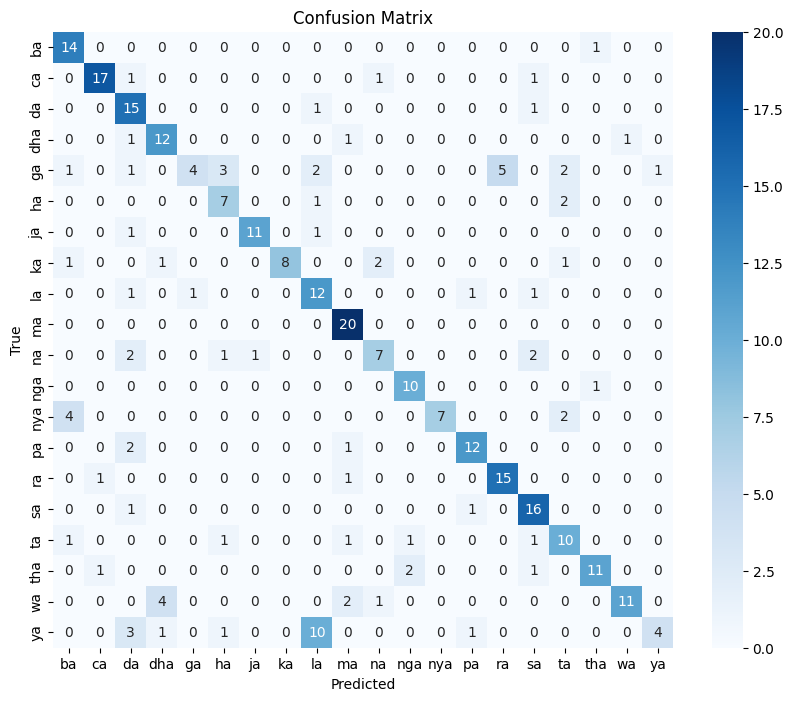

In [12]:
# Plot confusion matrix
def plot_confusion_matrix(targets, predictions, class_names):
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Tampilkan Confusion Matrix
plot_confusion_matrix(all_targets, all_predictions, full_dataset.classes)


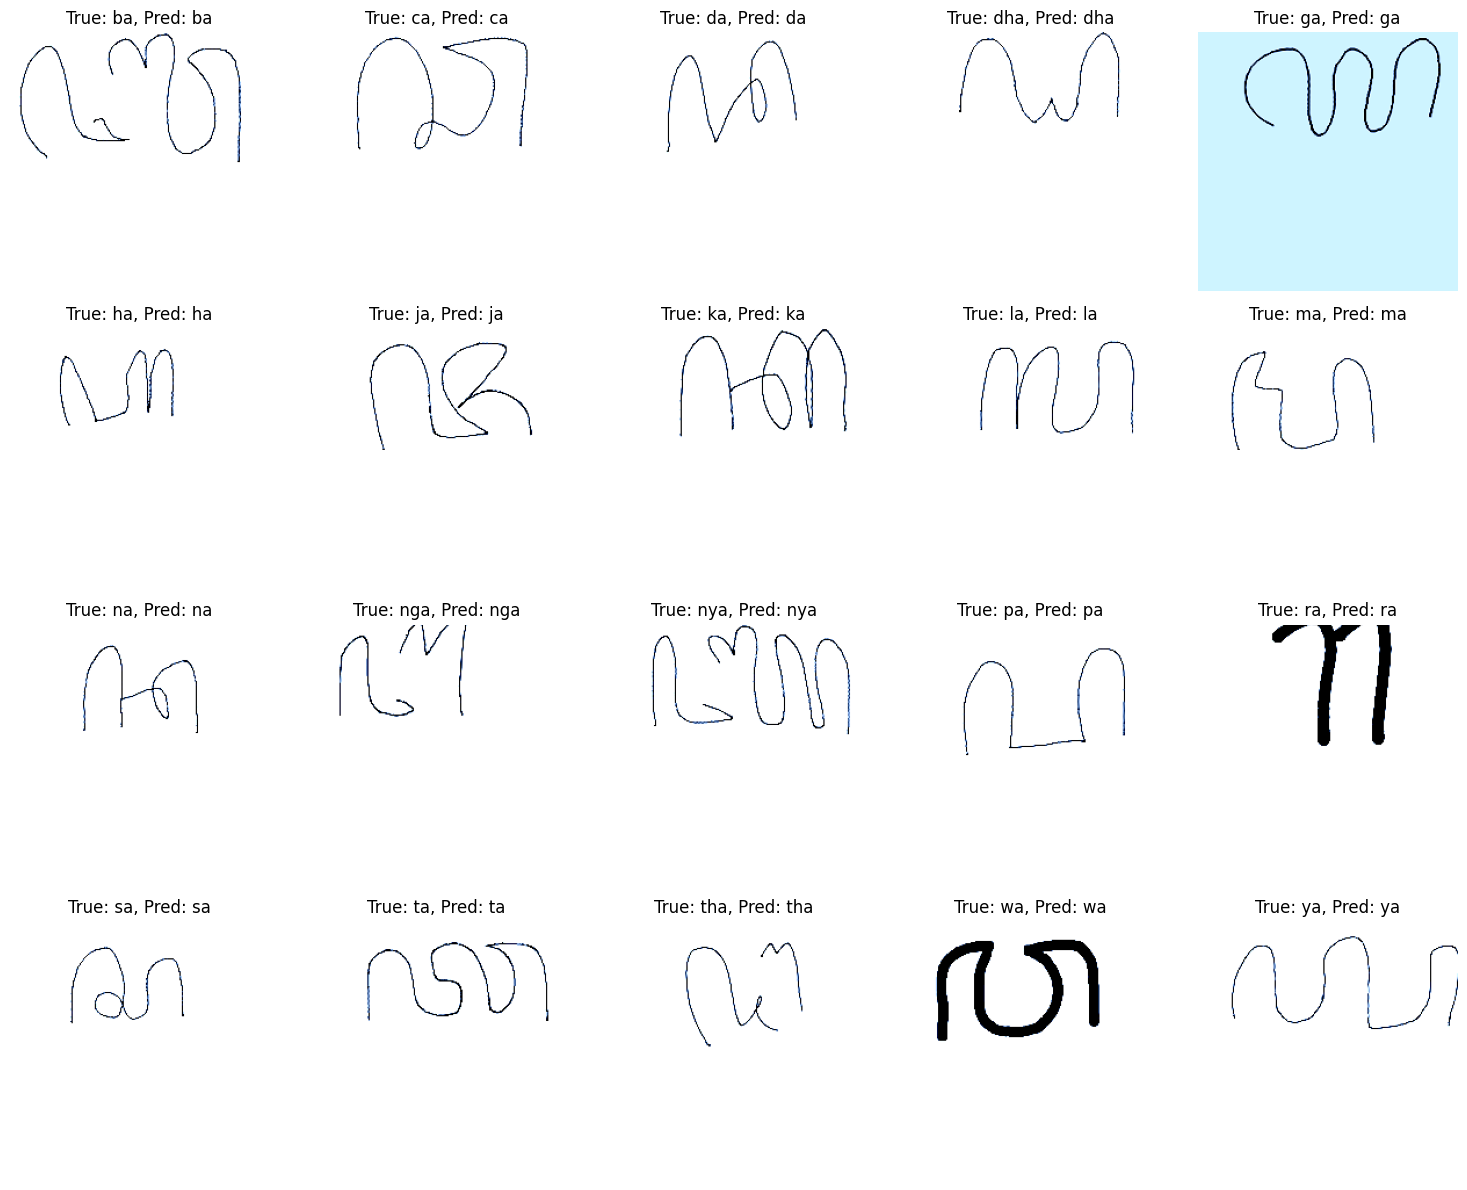

In [13]:
# Fungsi untuk menampilkan gambar per kelas dengan prediksi model
def show_predictions_per_class(model, dataset, num_classes=20, cols=5):
    model.eval()
    rows = (num_classes + cols - 1) // cols  # Menghitung jumlah baris sesuai kolom yang diinginkan
    fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))  # Ukuran figure menyesuaikan
    axs = axs.flatten()  # Meratakan axes untuk akses yang lebih mudah

    class_images = {i: None for i in range(num_classes)}

    for i in range(len(dataset)):
        image, label = dataset[i]
        image = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image).logits
            _, predicted = output.max(1)
            if class_images[label] is None and predicted.item() == label:
                class_images[label] = (image.squeeze().cpu(), label, predicted.item())
                if all(value is not None for value in class_images.values()):
                    break

    for i in range(num_classes):
        ax = axs[i]
        if class_images[i] is not None:
            img, true_label, pred_label = class_images[i]
            ax.imshow(img.permute(1, 2, 0).numpy())
            ax.set_title(f"True: {full_dataset.classes[true_label]}, Pred: {full_dataset.classes[pred_label]}")
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, 'No Prediction', ha='center', va='center')
            ax.axis('off')

    # Menonaktifkan axis kosong jika num_classes < rows * cols
    for j in range(num_classes, rows * cols):
        axs[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Menampilkan gambar prediksi
show_predictions_per_class(model, val_dataset)


In [14]:
# Cetak akurasi terbaik selama pelatihan
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


Best Validation Accuracy: 84.03%


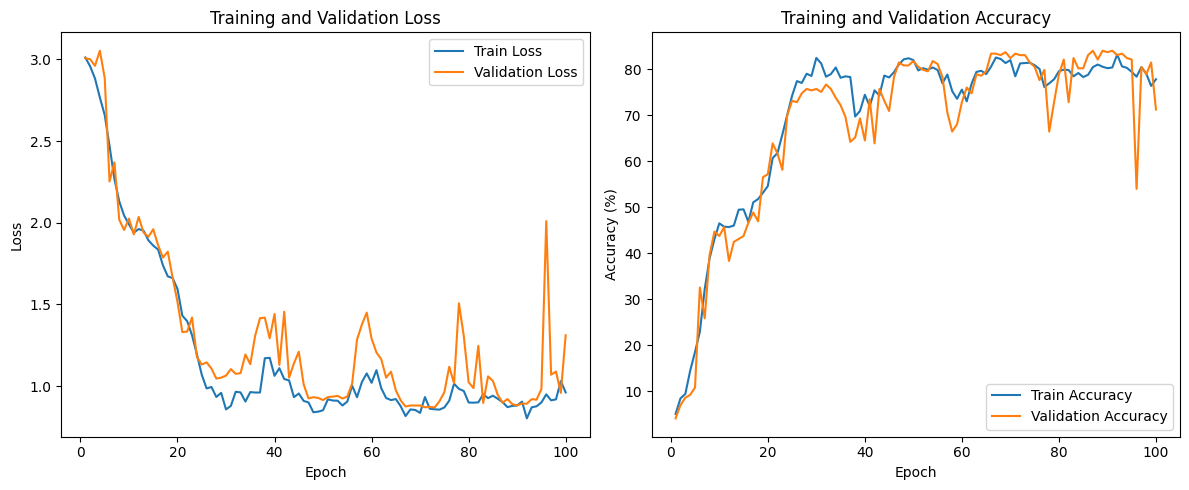

In [15]:
# Plotting Training and Validation Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
